In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import networkit as nk
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import phate
import pandas as pd
import umap

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from External.WS_Tree_dist import EMD_dist_tree_discretized, EMD_dist_tree_edge, plot_flow_discretized
from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp
from External.generation import create_graph
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances
plt.style.use('standard.mplstyle')

# Hyperparameters
mode = "K_Nearest+Density"   # mode for the graph construction
gamma = 5                    # Gamma for the triangle break

metric = "euclidean"         # Metric for the k-means clustering
ε, δ = 0.03, 0.1             # Values for the estimation of the k for k-means


# Load the Data

In [3]:
labels2 = pd.read_csv("~/Data/eth_reduced/obs.csv",header=0)
position = pd.read_csv("~/Data/eth_reduced/X_chronic.csv",header=None)

position = position.to_numpy()
labels_unique = list(labels2["annot"].unique())
labels = labels2["annot"].to_numpy()

number_of_nodes = len(position)

In [4]:
# calculate the UMAP embedding. In the plots replace position with embedding
try:
    embedding = np.load("./Output/Data/umap_eth_reduced_embedding.npy")
except:
    reducer = umap.UMAP(min_dist=0.8,random_state=42)
    # scaled_data = StandardScaler().fit_transform(position)
    scaled_data = position
    embedding = reducer.fit_transform(scaled_data)
    
    try:
        np.save("./Output/Data/umap_eth_reduced_embedding.npy", embedding)
    except:
        print("was not able to save the embedding")

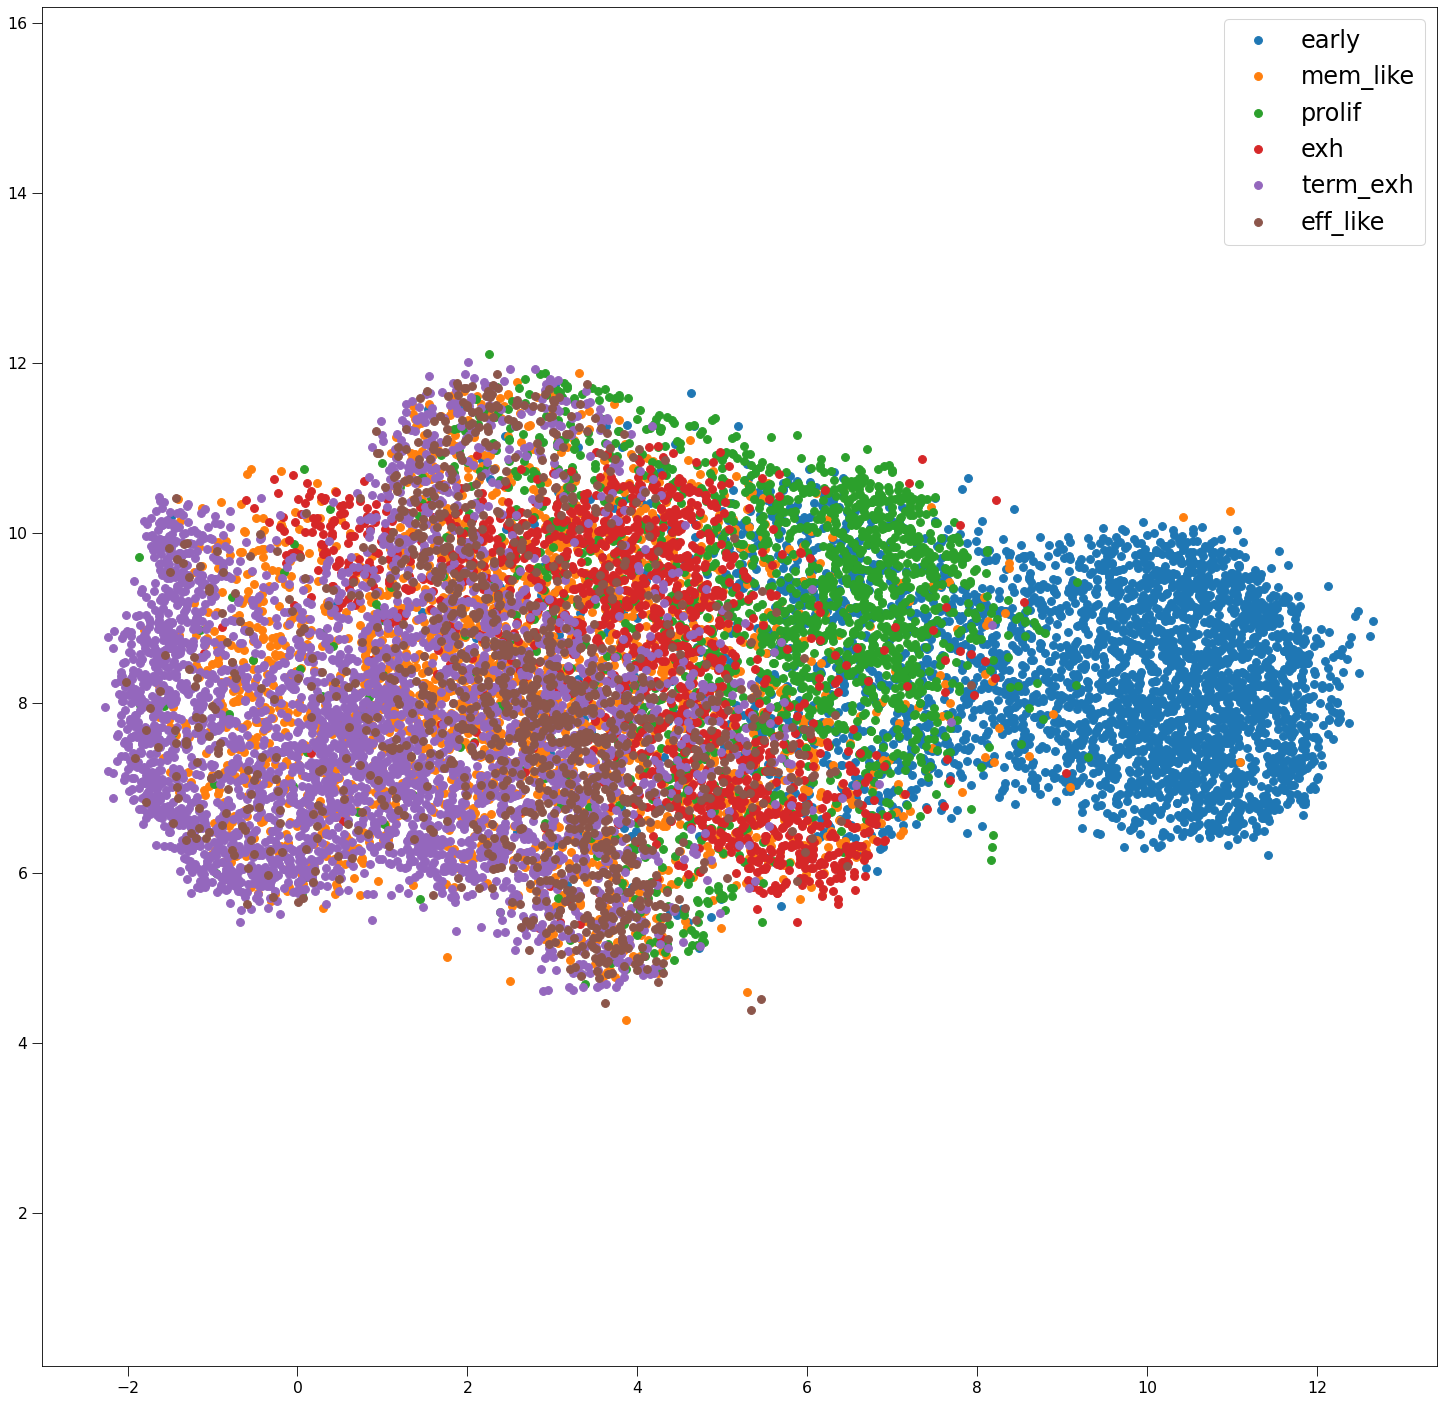

In [5]:
fig, ax = plt.subplots(1,1, figsize=(24,24))
for label in labels_unique:
    plt.plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
ax.axis("equal")
plt.legend()
plt.show()

# Create the k nearest graph

In [6]:
k = 11

G_matrix = kneighbors_graph(StandardScaler().fit_transform(position),
                            n_neighbors=k, mode='distance')
G = nx.from_scipy_sparse_matrix(G_matrix)
G = nk.nxadapter.nx2nk(G, weightAttr="weight")

In [7]:
for elem in G_matrix:
    print(elem)
    break

  (0, 4735)	81.42976719208049
  (0, 3089)	87.05097022411915
  (0, 1237)	88.4541371976424
  (0, 1227)	96.66758134405706
  (0, 975)	97.41822811369906
  (0, 3404)	97.55790012224344
  (0, 4902)	97.79127370325715
  (0, 646)	97.88497130643263
  (0, 1329)	97.92927519599452
  (0, 2931)	97.98098475330836
  (0, 930)	98.24149459677369


# Density analysis

In [8]:
distances = pairwise_distances(StandardScaler().fit_transform(position), 
                               StandardScaler().fit_transform(position),
                               n_jobs=-1)

In [9]:
radius = 1.25*G.totalEdgeWeight()/(G.numberOfEdges())

density = np.zeros(G.upperNodeIdBound())

for u in tqdm(G.iterNodes(), desc="calculating the densities for the density criterion", 
              total=G.numberOfNodes()):
    dist = distances[u]
    numbers = np.sum(dist<=radius)
    density[u] = numbers

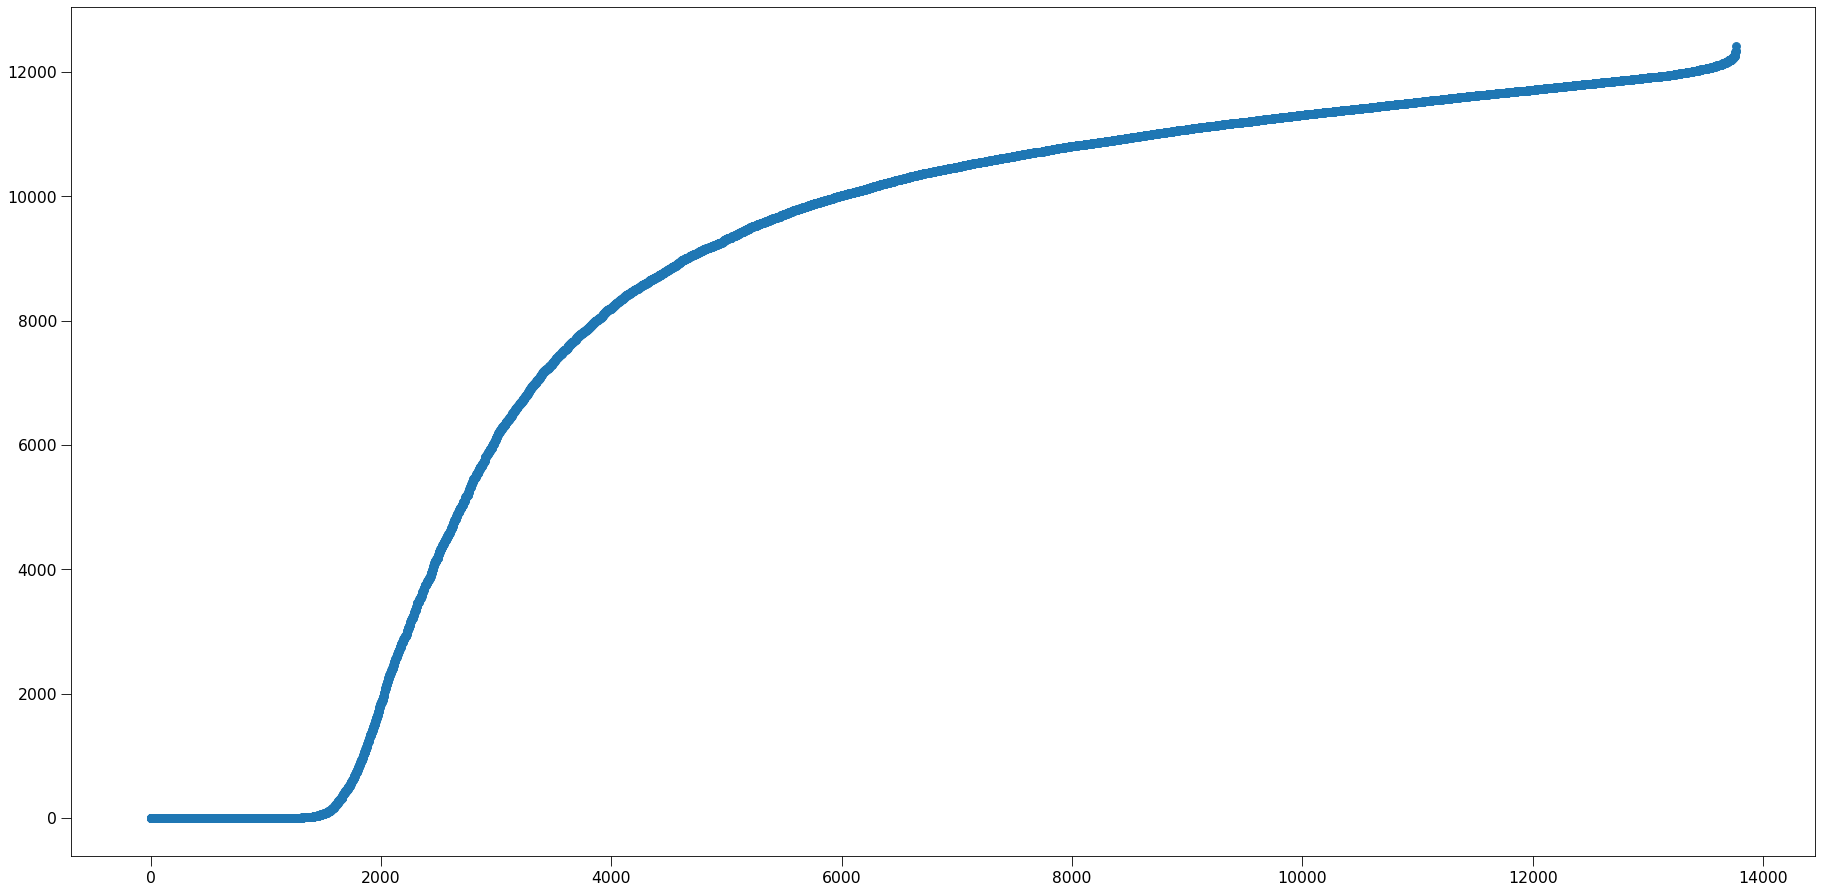

In [10]:
 plt.plot(sorted(density))

In [11]:
np.std(distances)

26.12729059166629

In [12]:
np.mean(distances)

95.15967994029151

In [13]:
from External.create_k_nearest import is_connected

In [14]:
is_connected(G)

True